<a href="https://colab.research.google.com/github/Daiyan-Zubaier/Stock-Price-Predictor/blob/main/Stock_Predictor_Daiyan_%26_Rajit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/jinglescode/time-series-forecasting-pytorch

In [772]:
%pip install --upgrade pip
%pip install torch numpy matplotlib yfinance

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import yfinance as yf

print("All libraries loaded.")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
All libraries loaded.


# Configuration Settings
Configures settings for libraries in a 2D hashmap


In [773]:
config = {
    #Collects stock price data
    "yahoo_finance": {
        "symbol": "IBM",
    },

    #Data preprocessing settings
    "data": {
        # number of past days to predict next price
        "window_size": 60,
        # 80% for training, 20% for testing
        "train_split_size": 0.80,
    },

    # Plotting settings
    "plots": {
        # Show data label every x days
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },

    # LSTM NN Settings
    "model": {
        # Number of features
        "input_size": 4,
        "num_lstm_layers": 1,
        "lstm_size": 64,
        # Disables neurons
        "dropout": 0.2,
    },
    
    "training": {
        "device": "cpu",
        "batch_size": 64,
        # Train for x cycles
        "num_epoch": 100,
        "learning_rate": 0.001,
        # Decreasing lr every x epochs
        "scheduler_step_size": 50,
    }
}

In [774]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

feature_scaler = Normalizer()
label_scaler = Normalizer()

Number data points: 4951 from 2005-08-22 to 2025-04-25
[[-1.51895044 -0.16253111 -1.53111536 -1.53321376]
 [-1.52690059 -0.50187172 -1.53143556 -1.53217766]
 [-1.5368036  -0.62174292 -1.53379674 -1.53214662]
 ...
 [ 3.85690928  1.26822242  3.72916128  3.86814948]
 [ 3.42744011 -4.52454392  3.69203986  3.84977174]
 [ 3.50934515  0.88694417  3.66041227  3.83764968]]
[[ 43.3232193 ]
 [ 43.02425766]
 [ 42.65185928]
 ...
 [245.47999573]
 [229.33000183]
 [232.41000366]]
4951
from 2005-08-22 to 2025-04-25


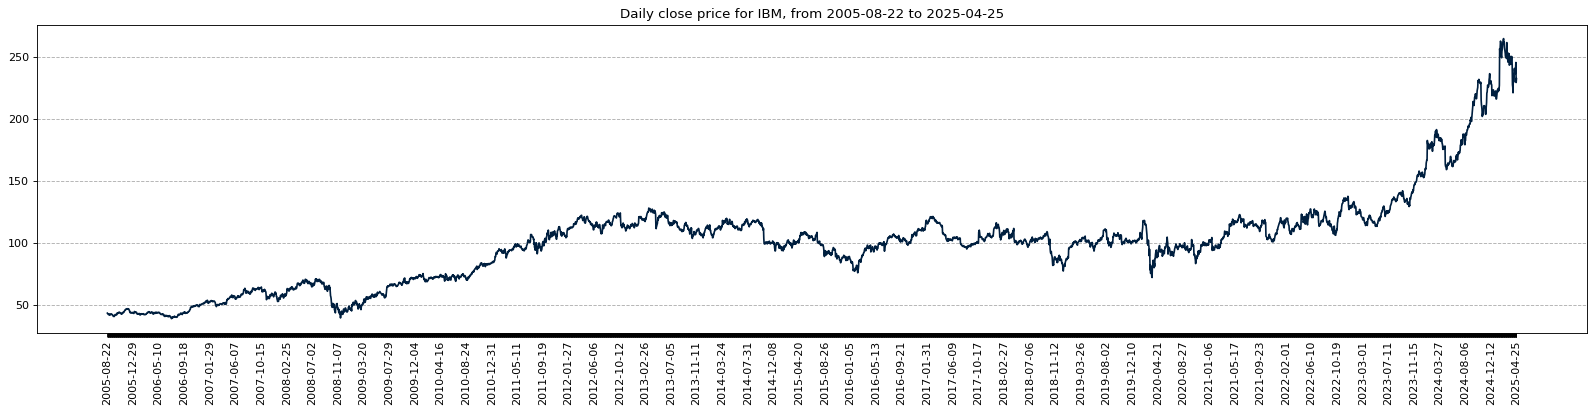

In [775]:
import requests

def download_data(config):
    symbol = config["yahoo_finance"]["symbol"]
    
    data = yf.download(symbol, period="max", interval="1d", progress=False)
    recent_years = 20
    total_years = data.index[-1].year - data.index[0].year + 1
    cutoff_index = int(len(data) * (recent_years / total_years))
    data = data[-cutoff_index:]

    data["daily_return"] = data["Close"].pct_change()
    data["7d_ma"] = data["Close"].rolling(window=7).mean()
    data["30d_ma"] = data["Close"].rolling(window=30).mean()
    data.dropna(inplace=True)

    if data.empty:
        raise ValueError(f"No data found for symbol {symbol}")

    data_date = data.index.strftime('%Y-%m-%d').tolist()
    data_close_price = data['Close'].values
    data_close_price = np.array(data_close_price)

    features_raw = data[["Close", "daily_return", "7d_ma", "30d_ma"]].values
    labels_raw = data["Close"].values.reshape(-1, 1)
    features = feature_scaler.fit_transform(features_raw)
    labels = label_scaler.fit_transform(labels_raw)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[-1]

    print("Number data points:", num_data_points, display_date_range)

    return data_date, data_close_price, features, labels, num_data_points, display_date_range


'''
data_date: List of dates.
data_close_price: NumPy array of closing prices.
num_data_points: Total number of data points.
display_date_range: A string indicating the range of dates.
'''

data_date, data_close_price, features, labels, num_data_points, display_date_range = download_data(config)

print(features)
print(data_close_price)
print(num_data_points)
print(display_date_range)

# plot

fig = plt.figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["yahoo_finance"]["symbol"] + ", " + display_date_range)
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.show()

In [776]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size, x.shape[1]), strides=(x.strides[0], x.strides[0], x.strides[1]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

features = feature_scaler.fit_transform(features)

data_x, data_x_unseen = prepare_data_x(features, window_size=config["data"]["window_size"])
data_y = prepare_data_y(labels.flatten(), window_size=config["data"]["window_size"])

# split dataset

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

## Dataloader class

Based on https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
Our class is a map-style dataset

In [777]:
class StockDataset(Dataset):
    def __init__(self, x, y):
        # expanding dimension of array, currently (batch, window), after (batch, window, features)
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], np.array([self.y[idx]], dtype=np.float32)

print("data_x_train", data_x_train.shape)
print("data_x_val", data_x_val.shape)
train_dataset = StockDataset(data_x_train, data_y_train)
val_dataset = StockDataset(data_x_val, data_y_val)

print("Train data shape", train_dataset.x.shape, train_dataset.y.shape)
print("Validation data shape", val_dataset.x.shape, val_dataset.y.shape)

train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=True)

data_x_train (3912, 60, 4)
data_x_val (979, 60, 4)
Train data shape (3912, 60, 4) (3912, 1)
Validation data shape (979, 60, 4) (979, 1)


In [ ]:
import os

model_path = f'stock_models/{config["yahoo_finance"]["symbol"]}.pth'

class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=64, num_layers=1, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)  # Projects input shape into hidden layer shape
        self.relu = nn.ReLU()     # Activation function

        # Defining LSTM model
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)  # Outputs back into input shape


    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)

        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for linear_2
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)

        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions

def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    # We don't want to change the NN during validation
    if is_training:
        model.train()
        # Randomly turn off neurons and data normalised
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):

        if is_training:
            # ensures that each batch starts with fresh gradients before backpropagation
            optimizer.zero_grad()

        batchsize = x.shape[0]

        # Move to GPU
        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)    # PyTorch automatically calls forward prop
        loss = criterion(out.contiguous(), y.squeeze(-1).contiguous())    # Mean squared error loss

        if is_training:
            loss.backward()     # Back prop
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Prevents explosive gradients
            optimizer.step()    # Update weights

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path), strict = False)
    print(f"Loaded model from {model_path}")
else:
    print(f"No saved model found for {config['yahoo_finance']['symbol']}, training new model.")


criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(),
    lr=config["training"]["learning_rate"],
    betas=(0.9, 0.98), eps=1e-9,
    weight_decay=config["training"].get("weight_decay", 1e-5))
scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=config["training"]["scheduler_step_size"],  # learning rate is adjusted (multiplied by gamma)
                                      gamma=0.5)


for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()    # Adjust lr

    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))
    
torch.save(model.state_dict(), f'stock_models/{config["yahoo_finance"]["symbol"]}.pth')
print(f"Model saved to {model_path}")

Loaded model from stock_models/IBM.pth
Epoch[1/100] | loss train:0.001874, test:0.065005 | lr:0.001000
Epoch[2/100] | loss train:0.001501, test:0.069720 | lr:0.001000
Epoch[3/100] | loss train:0.001687, test:0.060396 | lr:0.001000
Epoch[4/100] | loss train:0.001466, test:0.055873 | lr:0.001000
Epoch[5/100] | loss train:0.001621, test:0.060137 | lr:0.001000
Epoch[6/100] | loss train:0.001608, test:0.049292 | lr:0.001000
Epoch[7/100] | loss train:0.001628, test:0.050972 | lr:0.001000
Epoch[8/100] | loss train:0.001499, test:0.055778 | lr:0.001000
Epoch[9/100] | loss train:0.001538, test:0.050090 | lr:0.001000
Epoch[10/100] | loss train:0.001549, test:0.060267 | lr:0.001000
Epoch[11/100] | loss train:0.001569, test:0.056355 | lr:0.001000
Epoch[12/100] | loss train:0.001548, test:0.048808 | lr:0.001000
Epoch[13/100] | loss train:0.001555, test:0.066339 | lr:0.001000
Epoch[14/100] | loss train:0.001449, test:0.049499 | lr:0.001000
Epoch[15/100] | loss train:0.001590, test:0.054012 | lr:0.00

Predicted train shape: (3912,)
Predicted val shape: (979,)
Inverse transformed val shape: (4951,)


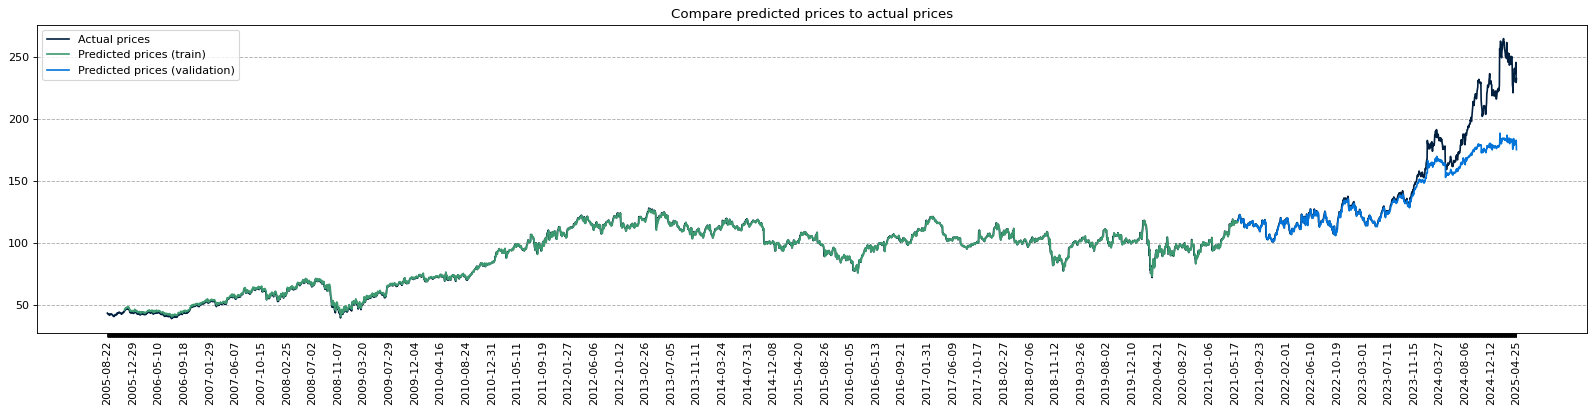

In [779]:

# re-initialize to ensure, data isnt shuffled when presenting data
train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()  # Prime for validation and testing

# predict on the training data, to see how well the model managed to learn and memorize
predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out.flatten()))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for (x, y) in val_dataloader:
    x = x.to(config["training"]["device"])
    out = model(x)                          # Forward prop
    out = out.cpu().detach().numpy().flatten()       # Converting output tensor into a numpy array
    predicted_val = np.concatenate((predicted_val, out))

# prepare data for plotting

to_plot_data_y_train_pred = np.full(num_data_points, np.nan)
to_plot_data_y_val_pred = np.full(num_data_points, np.nan)

to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = label_scaler.inverse_transform(predicted_train.reshape(-1, 1)).flatten()
val_start_idx = split_index + config["data"]["window_size"]
val_end_idx = val_start_idx + len(predicted_val)
to_plot_data_y_val_pred[val_start_idx:val_end_idx] = label_scaler.inverse_transform(predicted_val.reshape(-1, 1)).flatten()


print("Predicted train shape:", predicted_train.shape)
print("Predicted val shape:", predicted_val.shape)
print("Inverse transformed val shape:", to_plot_data_y_val_pred.shape)

# plots

fig = plt.figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

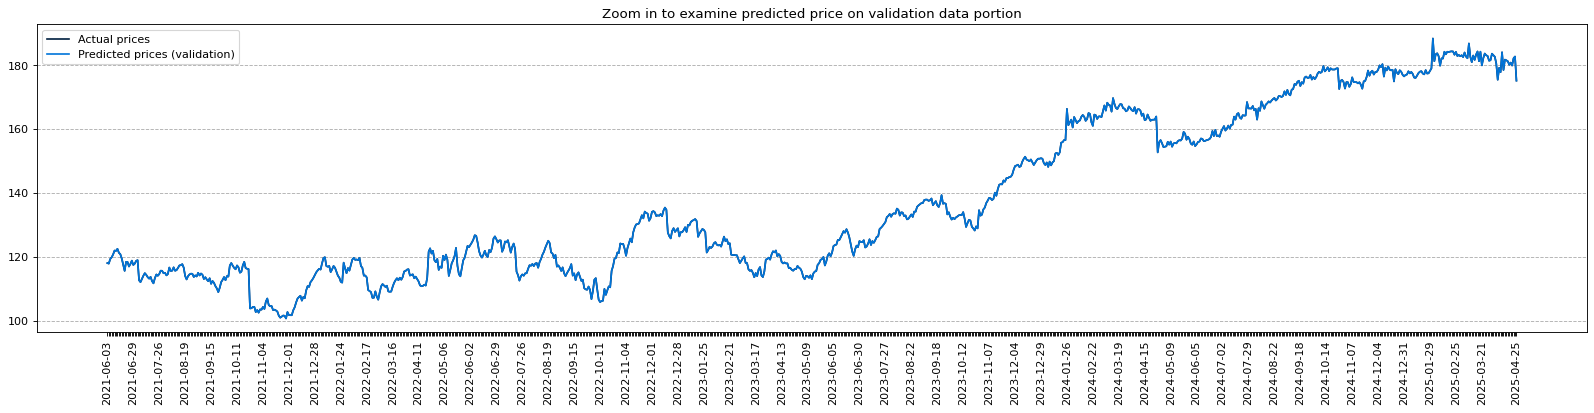

In [780]:
# prepare data for plotting the zoomed in view of the predicted prices (on validation set) vs. actual prices

to_plot_data_y_val_subset = label_scaler.inverse_transform(predicted_val.reshape(-1, 1)).flatten()
to_plot_predicted_val = label_scaler.inverse_transform(predicted_val.reshape(-1, 1)).flatten()
to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

# plots

fig = plt.figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(to_plot_data_date, to_plot_predicted_val.squeeze(), label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Zoom in to examine predicted price on validation data portion")
xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
xs = np.arange(0,len(xticks))
plt.xticks(xs, xticks, rotation='vertical')
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

C:\Users\mewan\AppData\Local\Temp\ipykernel_37696\1309013364.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_price_vector[0, 0] = next_price  # assuming you only predict the closing price


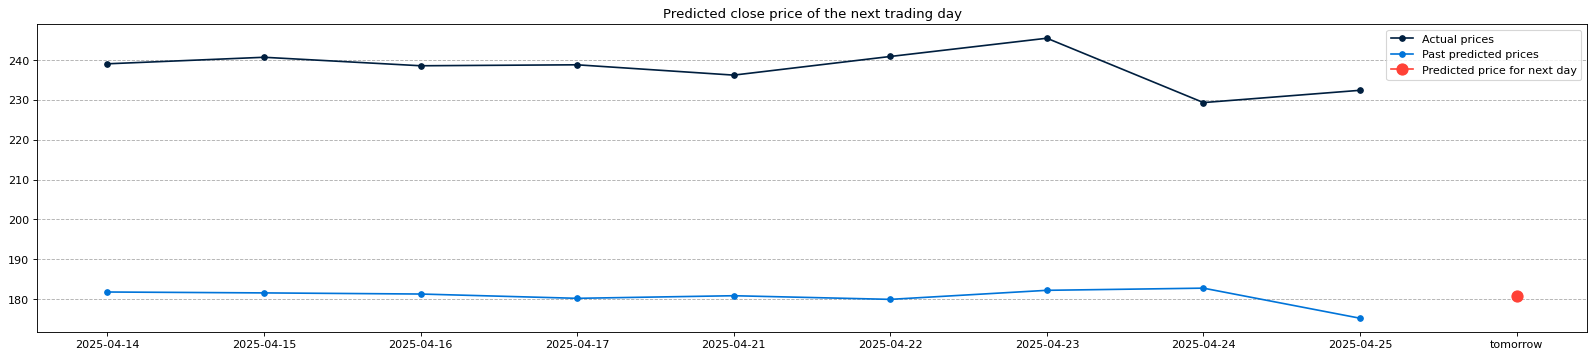

Predicted close price of the next trading day: 180.69


In [781]:
# predict the closing price of the next trading day

model.eval() # Prime for predicting (turn off dropout and normalize data)

predictions = np.array([])
current_sequence = data_x_unseen.copy()

forecast_time = 7

for i in range(forecast_time):
  x = torch.tensor(current_sequence).float().unsqueeze(0).to(config["training"]["device"]) # this is the data type and shape required, [batch, sequence, feature]
  next_price_tensor = model(x)       # Prediction
  next_price = next_price_tensor.cpu().detach().numpy()[0]
  predictions = np.append(predictions, next_price)
  next_price_vector = np.zeros((1, current_sequence.shape[1]))  # (1, 4)
  next_price_vector[0, 0] = next_price  # assuming you only predict the closing price
  current_sequence = np.concatenate((current_sequence[1:], next_price_vector), axis=0)




# --------------------------
# Prepare data for plotting
# --------------------------
plot_range = 10  # Number of days to plot (last 9 days + the predicted day)

# Initialize arrays to hold data for the last plot_range days
to_plot_data_y_val = np.zeros(plot_range)       # Actual validation prices
to_plot_data_y_val_pred = np.zeros(plot_range)    # Past predicted prices from validation
to_plot_data_y_test_pred = np.zeros(plot_range)   # Our forecast (next day's prediction)

# Fill the first plot_range-1 indices with actual and past predicted values
# (using the last plot_range-1 entries from the validation data)
to_plot_data_y_val[:plot_range-1] = label_scaler.inverse_transform(data_y_val[-plot_range+1:].reshape(-1, 1)).flatten()
to_plot_data_y_val_pred[:plot_range-1] = label_scaler.inverse_transform(predicted_val[-(plot_range-1):].reshape(-1, 1)).flatten()

# For the forecasted next day, use the first prediction from our predictions array.
# Convert the scalar into a 2D array so that scaler.inverse_transform works properly.
next_day_pred = label_scaler.inverse_transform(np.array([[predictions[0]]]))[0, 0]
to_plot_data_y_test_pred[plot_range-1] = next_day_pred

# Replace zeros with None so that they are not plotted (this creates gaps where there is no data)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# Prepare the x-axis dates: take the last plot_range-1 dates and append "tomorrow"
plot_date_test = list(data_date[-plot_range+1:])  # Ensure we have a list of dates
plot_date_test.append("tomorrow")

# --------------------------
# Plot the data
# --------------------------
fig = plt.figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
plt.title("Predicted close price of the next trading day")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

print("Predicted close price of the next trading day:", round(to_plot_data_y_test_pred[plot_range-1], 2))


In [782]:
print(model)

LSTMModel(
  (linear_1): Linear(in_features=4, out_features=64, bias=True)
  (relu): ReLU()
  (lstm): LSTM(64, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)


In [783]:
import os
import torch
#from google.colab import files

symbol = "IBM" 

save_dir = "stock_models"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, f"{symbol}.pth")
torch.save(model.state_dict(), save_path)

#files.download(save_path)